In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Concatenate several datasets

In [2]:
def get_dataset(directory):
    list_dir = [file for file in os.listdir(directory) if file.endswith('.csv')]
    dfs = []
    for file in list_dir:
        file_path = os.path.join(directory, file)
        df = pd.read_csv(file_path)
        df.dropna(how='all', inplace=True, ignore_index=True)
        if '_metro' in file:
            df['metro'] = 1
        else: 
            df['metro'] = 0
        dfs.append(df)

    concatenated_df = pd.concat(dfs, ignore_index=True)

    return concatenated_df    

In [3]:
flats = get_dataset('datasets')

In [4]:
flats.to_csv('flats.csv', index=False)

In [5]:
flats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25769 entries, 0 to 25768
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   price   25769 non-null  object
 1   dist1   25769 non-null  object
 2   dist2   25608 non-null  object
 3   dist3   24226 non-null  object
 4   rooms   25769 non-null  object
 5   square  25769 non-null  object
 6   floor   25769 non-null  object
 7   type1   22015 non-null  object
 8   type2   20235 non-null  object
 9   type3   20647 non-null  object
 10  metro   25769 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 2.2+ MB


## Removing duplicates

In [6]:
flats.drop_duplicates(subset=['price', 'dist1', 'dist2', 'dist3', 'rooms', 'square', 'floor', 'type1', 'type2', 'type3'],
                   inplace=True, ignore_index=True)

In [7]:
flats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15547 entries, 0 to 15546
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   price   15547 non-null  object
 1   dist1   15547 non-null  object
 2   dist2   15453 non-null  object
 3   dist3   14504 non-null  object
 4   rooms   15547 non-null  object
 5   square  15547 non-null  object
 6   floor   15547 non-null  object
 7   type1   13101 non-null  object
 8   type2   11979 non-null  object
 9   type3   12855 non-null  object
 10  metro   15547 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1.3+ MB


## Fix column values

Columns dist1, dist2, and dist3 represent residential complex, microdistrict, and districts respectively. But some flat advertisements don't have all three recordings so that district can be recorded in the dist2 or dist1 column.

In [9]:
flats.dist3.value_counts()

dist3
Київ              7518
Печерський        2357
Голосіївський     1165
Дарницький         934
Шевченківський     768
Солом'янський      464
Дніпровський       449
Оболонський        303
Подільський        291
Святошинський      193
Деснянський         62
Name: count, dtype: int64

In [10]:
flats.dist3 = flats.dist3.apply(lambda x : np.nan if x=='Київ' else x)

In [11]:
districts = ['Печерський', 'Деснянський', 'Шевченківський', 'Дніпровський', 'Голосіївський',
             "Солом'янський", 'Святошинський', 'Оболонський', 'Дарницький', 'Подільський']

In [12]:
for i in range(0, len(flats)):
    if flats.dist1[i] in districts:
        flats.loc[i, 'dist3'] = flats.dist1[i]
        flats.loc[i, 'dist1'] = np.nan
    elif flats.dist2[i] in districts:
        flats.loc[i, 'dist3'] = flats.dist2[i]
        flats.loc[i, 'dist2'] = np.nan
    

The same situation with columns type1, type2 type3. Columns type1 and type2 have to contain information about the type of the building and column type3 - the year. But sometimes the year is recorded in type1 or type2 columns.

In [13]:
import re
pattern = r'\d{4}'
for i in range(0, len(flats)):
    if re.match(pattern, str(flats.type1[i])):
        flats.loc[i, 'type3'] = flats.type1[i]
        flats.loc[i, 'type1'] = np.nan
    elif re.match(pattern, str(flats.type2[i])):
        flats.loc[i, 'type3'] = flats.type2[i]
        flats.loc[i, 'type2'] = np.nan

In [14]:
flats.head()

,price,dist1,dist2,dist3,rooms,square,floor,type1,type2,type3,metro
0,26 000 грн,ЖК Місце мрії,Шулявка,Солом'янський,2 кімнати,60 / 35 / 15 м²,поверх 14 з 25,спец. проект,монолітно-каркасний,2009.0,1
1,95 750 грн,ЖК Central Park,Нова забудова,Печерський,3 кімнати,131 / 80 / 15 м²,поверх 10 з 25,NaN,NaN,NaN,1
2,57 450 грн,ЖК Новопечерські Липки,Чорна Гора,Печерський,2 кімнати,87 / 41 / 17 м²,поверх 2 з 23,спец. проект,монолітно-каркасний,2013.0,1
3,8 000 грн,Харьківський,NaN,Дарницький,1 кімната,40 / 18 / 9 м²,поверх 3 з 16,серія Т,утеплена панель,1983.0,1
4,15 000 грн,ЖМ Патріотика,Осокорки,Дарницький,1 кімната,38 / 12 / 16 м²,поверх 15 з 25,спец. проект,панельні,2018.0,1


## Fix values type

### Fix price column values

In [15]:
flats.price = flats.price.apply(lambda x:  x.replace(' ', '')) #delete space between numbers
flats.price.replace('[^0-9]', '', regex=True, inplace=True) #delete all not numeric symbols
flats.price = flats.price.astype('int32') 

### Fix rooms column values

In [16]:
flats.rooms.unique()

array(['2 кімнати', '3 кімнати', '1 кімната', '4 кімнати', '6 кімнат',
       '5 кімнат'], dtype=object)

In [17]:
flats['rooms'].replace('[^0-9]', '', regex=True, inplace=True)
flats['rooms'] = flats.rooms.astype('int32')

### Fix area column values

In [18]:
flats['square'].replace('м²', '', inplace=True, regex=True)

str_split = flats.square.str.split(' / ') # split area values in three separate columns

flats['total_area'] = pd.to_numeric(str_split.str.get(0), errors='coerce') 
flats['living_area'] = pd.to_numeric(str_split.str.get(1), errors='coerce')
flats['kitchen_area']= pd.to_numeric(str_split.str.get(2), errors='coerce')
flats.head()

,price,dist1,dist2,dist3,rooms,square,floor,type1,type2,type3,metro,total_area,living_area,kitchen_area
0,26000,ЖК Місце мрії,Шулявка,Солом'янський,2,60 / 35 / 15,поверх 14 з 25,спец. проект,монолітно-каркасний,2009.0,1,60.0,35.0,15.0
1,95750,ЖК Central Park,Нова забудова,Печерський,3,131 / 80 / 15,поверх 10 з 25,NaN,NaN,NaN,1,131.0,80.0,15.0
2,57450,ЖК Новопечерські Липки,Чорна Гора,Печерський,2,87 / 41 / 17,поверх 2 з 23,спец. проект,монолітно-каркасний,2013.0,1,87.0,41.0,17.0
3,8000,Харьківський,NaN,Дарницький,1,40 / 18 / 9,поверх 3 з 16,серія Т,утеплена панель,1983.0,1,40.0,18.0,9.0
4,15000,ЖМ Патріотика,Осокорки,Дарницький,1,38 / 12 / 16,поверх 15 з 25,спец. проект,панельні,2018.0,1,38.0,12.0,16.0


### Fix floor column values

In [19]:
flats['floor'].replace('поверх', '', regex=True, inplace=True)

str_split = flats.floor.str.split(' з ')

flats['floor'] = pd.to_numeric(str_split.str.get(0), errors='coerce', downcast='integer') 
flats['floor_total'] =  pd.to_numeric(str_split.str.get(1), errors='coerce', downcast='integer')


### Fix year column values

In [20]:
flats.rename(columns= {'type3' :'year'}, inplace = True)
flats.year = pd.to_numeric(flats.year, errors='coerce', downcast='integer') 

## Null values

In [21]:
flats.isna().sum()

price              0
dist1            803
dist2           7518
dist3            334
rooms              0
square             0
floor              2
type1           2635
type2           4060
year            7726
metro              0
total_area         0
living_area     5206
kitchen_area     248
floor_total      152
dtype: int64

In [22]:
flats.dropna(subset = ['dist3', 'floor'], inplace=True, ignore_index=True)

In [23]:
flats.drop(['dist1', 'dist2', 'square', 'type1', 'type2'], axis = 1, inplace=True)

In [24]:
flats.rename(columns= {'dist3': 'district'}, inplace = True)

In [25]:
flats.isna().sum()

price              0
district           0
rooms              0
floor              0
year            7502
metro              0
total_area         0
living_area     5113
kitchen_area     246
floor_total      150
dtype: int64

In [26]:
flats.drop(['living_area', 'year'], axis = 1, inplace = True)

In [27]:
flats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15211 entries, 0 to 15210
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         15211 non-null  int32  
 1   district      15211 non-null  object 
 2   rooms         15211 non-null  int32  
 3   floor         15211 non-null  float64
 4   metro         15211 non-null  int64  
 5   total_area    15211 non-null  float64
 6   kitchen_area  14965 non-null  float64
 7   floor_total   15061 non-null  float64
dtypes: float64(4), int32(2), int64(1), object(1)
memory usage: 832.0+ KB


## Summary statistics for numeric features

In [28]:
flats.describe()

,price,rooms,floor,metro,total_area,kitchen_area,floor_total
count,1.521100e+04,15211.000000,15211.000000,15211.000000,15211.000000,14965.000000,15061.000000
mean,3.823504e+04,2.209914,9.041549,0.400434,80.515758,15.974959,16.200186
std,1.098170e+05,1.041567,6.429815,0.490002,57.404154,10.534743,8.221015
min,9.990000e+02,1.000000,1.000000,0.000000,9.000000,1.000000,1.000000
25%,1.300000e+04,1.000000,4.000000,0.000000,46.000000,9.000000,9.000000
50%,2.290200e+04,2.000000,7.000000,0.000000,63.000000,14.000000,16.000000
75%,4.580300e+04,3.000000,13.000000,1.000000,98.000000,20.000000,24.000000
max,1.129850e+07,6.000000,53.000000,1.000000,1800.000000,210.000000,48.000000


## Fix outliers

There are some extremely big values in price, total_area, and kitchen_area, that look like mistakes. Also, the max value in the floor_total column is 48, but in column floor, the max value is 53.

<Axes: >

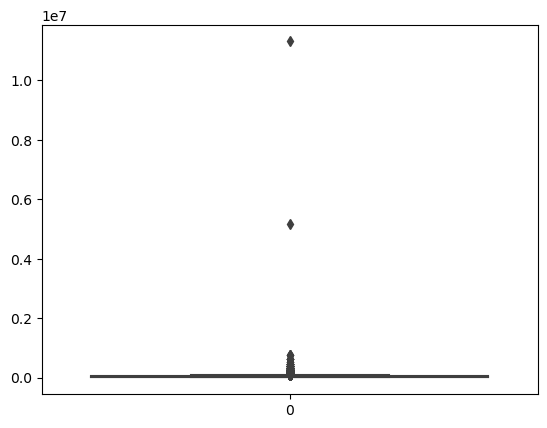

In [29]:
sns.boxplot(flats.price)

<Axes: >

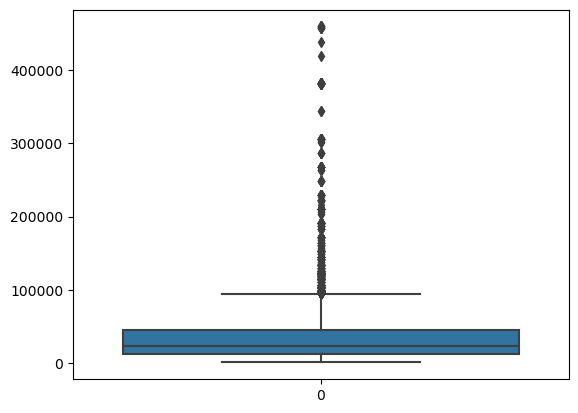

In [30]:
flats = flats[flats.price<500000]
sns.boxplot(flats.price)

<Axes: >

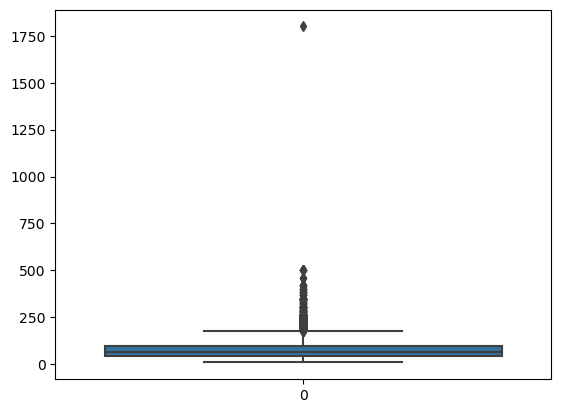

In [32]:
sns.boxplot(flats.total_area)

<Axes: >

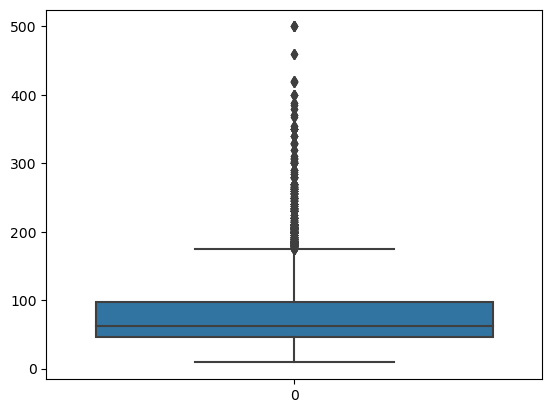

In [33]:
flats = flats[flats.total_area <600]
sns.boxplot(flats.total_area)

<Axes: >

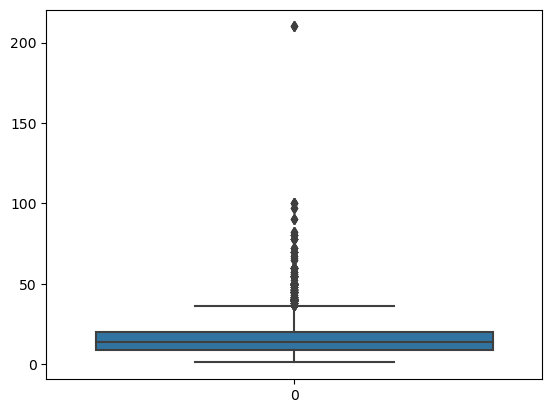

In [34]:
sns.boxplot(flats.kitchen_area)

<Axes: >

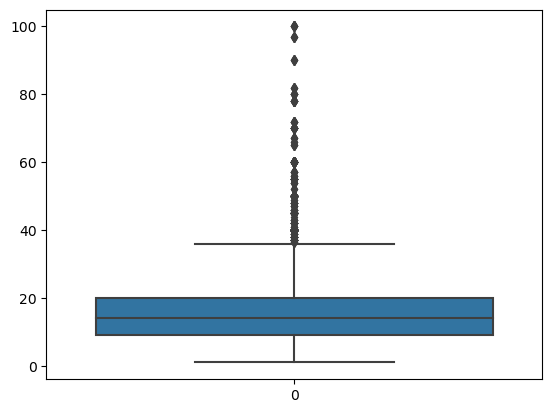

In [35]:
flats = flats[flats.kitchen_area <150]
sns.boxplot(flats.kitchen_area)

In [36]:
flats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14947 entries, 0 to 15210
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         14947 non-null  int32  
 1   district      14947 non-null  object 
 2   rooms         14947 non-null  int32  
 3   floor         14947 non-null  float64
 4   metro         14947 non-null  int64  
 5   total_area    14947 non-null  float64
 6   kitchen_area  14947 non-null  float64
 7   floor_total   14914 non-null  float64
dtypes: float64(4), int32(2), int64(1), object(1)
memory usage: 1.4+ MB


In [37]:
flats[flats.floor >48]

,price,district,rooms,floor,metro,total_area,kitchen_area,floor_total
8412,61280,Печерський,3,53.0,0,125.0,20.0,5.0


In [38]:
flats.drop(8412, inplace=True)
flats.reset_index(inplace=True, drop=True)

In [39]:
flats.to_csv('flats_cleaned.csv', index=False)